In [3]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_simple
import ariel_gp
import ariel_load
import ariel_load_FGS
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import importlib
from tqdm import tqdm
kgs.debugging_mode = 1
kgs.profiling=False
kgs.n_workers = 4

local


In [4]:
train_data = kgs.load_all_train_data()
train_data = train_data[:1099]

In [5]:
# importlib.reload(kgs)
# for d in train_data:
#     d.spectrum_cov = np.ones((283,283))
# kgs.mats_to_data(train_data, train_data, kgs.data_to_mats(train_data,train_data))
# kgs.score_metric(train_data, train_data)

In [6]:
import cupy as cp
def get_brightness(d):
    d = copy.deepcopy(d)
    d.load_to_step(5, ariel_load.default_loaders())
    return cp.sum(d.transits[0].data[0].data).get()
brightness = [get_brightness(d) for d in tqdm(train_data)]
kgs.clear_gpu()

100%|███████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:14<00:00, 75.18it/s]


In [24]:
loaded = kgs.dill_load(kgs.temp_dir + 'evaluate_model_New transit prior, alpha=1.0, FGSs=0.0001__1099.pickle')

In [25]:
model = copy.deepcopy(loaded[1])
print(model.sigma_fudge_FGS, model.sigma_offset)
model.sigma_fudge_FGS = 1.
model.sigma_fudge_AIRS_mean = 1.
model.sigma_fudge_AIRS_var = 1.
model.sigma_offset = [0.,0.]
inferred_data = model.infer(train_data);
inferred_data[0].spectrum_cov[0,0]

2.4519319490767026 [-1.102304551152567e-06, 8.49708607848487e-06]


1.1822606382489244e-09

336892234.03466225
326385128.20089495


(-10.0, 10.0)

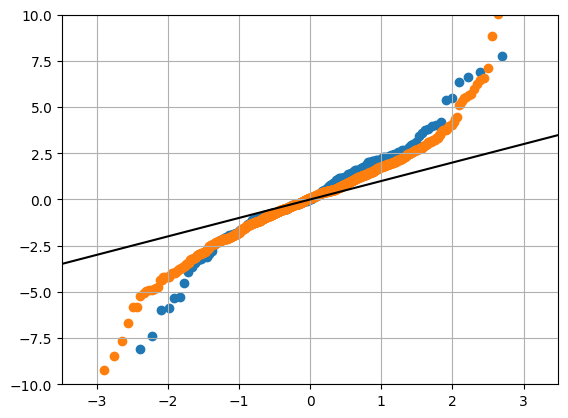

In [26]:
import scipy.stats as stats
import matplotlib.pyplot as plt
    
error_matrix = np.array([d.spectrum - t.spectrum for d,t in zip(inferred_data,train_data)])
true_matrix = np.array([t.spectrum for d,t in zip(inferred_data,train_data)])


slic = slice(2,283)
y = np.mean(error_matrix[:,slic],1)
sigma = np.array([np.sqrt(np.mean(d.spectrum_cov[slic,slic])) for d in inferred_data])
y_norm = y/sigma

splitter = sigma
#splitter = np.mean(true_matrix,1)
#splitter = np.array([d.planet_id for d in train_data])
splitter = np.array(brightness)
#inds = np.argsort(splitter)

plt.figure()
plt.grid(True)
N_split = 200
for i_half in [0,1]:

    if i_half==0:
        y_norm_here = y_norm[inds[:N_split]]
        print(np.mean(splitter[inds[:N_split]]))
    else:
        y_norm_here = y_norm[inds[N_split:]]
        print(np.mean(splitter[inds[N_split:]]))
    
    #y_norm_here =  y_norm

    osm, osr = stats.probplot(y_norm_here, dist="norm", plot=None, fit=False)
    plt.scatter(osm,osr)
plt.axline( (0,0), slope=1, color='black')
plt.ylim([-10,10])
#plt.xlim([-4,4])

In [20]:
if True:
    kgs.debugging_mode = 1
    model = ariel_gp.PredictionModel()
    model.run_in_parallel = False
    model.model_options.n_iter=0
    model.model_options.use_training_labels = True
    model.train(train_data)
    loaded_res = kgs.dill_load(kgs.temp_dir + '/prep2.pickle')
    model.infer(train_data[0:1]);
    transits = []
    times=[]
    FGS_noise = []
    for d,r in tqdm(zip(train_data,loaded_res)):
        mm= copy.deepcopy(model.results['model_mean'])
        mm= copy.deepcopy(model.results['model_mean'])
        mm.m['signal'].m['main'].m['transit'].transit_params[0][0] = d.transit_params
        mm.m['signal'].m['main'].m['transit'].transit_params[0][0].u = [0,0]
        mm.m['signal'].m['main'].m['transit'].transit_params[0][1] = d.transit_params
        mm.m['signal'].m['main'].m['transit'].transit_params[0][1].u = [0,0]
        mm.set_parameters(r[0])
        mm.m['signal'].m['main'].m['transit'].depth_model.offset = -d.diagnostics['training_spectrum']    
        obs_transit = copy.deepcopy(model.results['obs'])
        
        obs_noise = copy.deepcopy(model.results['obs'])
        noise_labels = mm.m['noise'].get_prediction(obs_noise)
        obs_noise.labels= noise_labels
        FGS_noise.append(obs_noise.export_matrix(False))

        #stellar_labels = mm.m['signal'].m['main'].m['spectrum'].get_prediction(obs_transit)
        transit_labels = mm.m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
        obs_transit.labels = transit_labels
        #obs_transit.labels = model.results['model_mean'].m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
        #obs_transit.labels = mm.m['signal'].m['main'].get_prediction(obs_transit)
        #obs_transit.labels = mm.m['signal'].get_prediction(obs_transit)
        #print(mm.m['signal'].m['main'].m['transit'].get_parameters())
        #d.diagnostics['transit'] = obs_transit        
        transits.append(copy.deepcopy(obs_transit.export_matrix(False)))
        obs_transit.labels = obs_transit.df['time'].to_numpy()[:,None]
        times.append(copy.deepcopy(obs_transit.export_matrix(False)))                     
    del loaded_res
    del mm
    del model
    transits = np.array(np.stack(transits))
    times = np.array(np.stack(times))
    FGS_noise = np.array(np.stack(FGS_noise))
    kgs.dill_save(kgs.temp_dir + 'FGS_transit_zones.pickle', (FGS_noise,transits,times))
    
FGS_noise,transits,times = kgs.dill_load(kgs.temp_dir + 'FGS_transit_zones.pickle')

KeyboardInterrupt: 

In [ ]:
# noise_arrays = []
# for d,tran in zip(tqdm(train_data), transits):
#     d=copy.deepcopy(d)
#     d.load_to_step(5, ariel_load.default_loaders())
#     FGS_data = d.transits[0].data[0].data.get()[:,0]
#     tran = tran[:,0]
#     mid_ind = np.argwhere(tran<1)[0][0]
#     noise_arrays.append(FGS_data[:mid_ind][tran[:mid_ind]==1])
#     noise_arrays.append(FGS_data[mid_ind:][tran[mid_ind:]==1])
#     #FGS_data_no_transit = FGS_data[:,0][tran[:,0]==1]

In [ ]:
#plt.figure()
import ariel_numerics

plt.figure()
for synth in [False, True]:
    
    result= []
    n_done = 0
    for d,tim,tran in zip(train_data,tqdm(times),transits):
        d=copy.deepcopy(d)
        d.load_to_step(5, ariel_load.default_loaders())
        tim = copy.deepcopy(tim[:,0])
        tran = copy.deepcopy(tran[:,0])
        mid_ind = np.argwhere(tran<1)[0][0]        
        FGS_data = d.transits[0].data[0].data.get()[:,0]
        if synth:
            FGS_data = np.random.default_rng(seed=np.round(np.abs(FGS_data[0])).astype(int)).standard_normal(FGS_data.shape)
            
    
        if np.sum(tran==1)<100:
            continue
        ft = np.polynomial.polynomial.Polynomial.fit(tim[tran==1], FGS_data[tran==1], 3)
        FGS_data = FGS_data - ft(tim)        
        
        noise_arrays=[]
        noise_arrays.append(FGS_data[:mid_ind][tran[:mid_ind]==1])
        noise_arrays.append(FGS_data[mid_ind:][tran[mid_ind:]==1])
        for n in noise_arrays:
            if len(n)>200:
                #print(len(n))
                #x=np.arange(len(n))      
                #if synth:
                #    n = np.random.default_rng(seed=np.round(n[0]).astype(int)).standard_normal(n.shape)
                #ft = np.polynomial.polynomial.Polynomial.fit(x, n, 2)
                #res = n - ft(x)            
                #plt.plot(res)
                
                res = copy.deepcopy(n)
                
                

                base_noise_est = ariel_numerics.estimate_noise_cp(cp.array(res), window_size=25, degree=3)
                
                #plt.plot(res/base_noise_est)


                lf_content = res - ariel_numerics.remove_trend_cp(cp.array(res), window_size=25, degree=3).get()

                result.append(base_noise_est/kgs.rms(lf_content))
                n_done+=1
    print(np.mean(result), np.std(result), np.std(result)/np.sqrt(n_done))
    plt.plot(result)
plt.legend(('Real', 'Synthetic'))
            
            
        
#         y = res
        
#         def autocorr(x, max_lag=None):
#             x = np.asarray(x)
#             x = x - np.mean(x)
#             result = np.correlate(x, x, mode='full')
#             result = result[result.size // 2:]  # keep non-negative lags
#             result /= result[0]  # normalize
#             if max_lag is not None:
#                 result = result[:max_lag+1]
#             return result

#         # compute autocorrelation
#         lags = 40
#         ac = autocorr(y, max_lag=lags)

#         # plot
#         plt.figure()
#         plt.stem(range(len(ac)), ac, use_line_collection=True)
#         plt.xlabel("Lag")
#         plt.ylabel("Autocorrelation")
#         plt.title("Autocorrelation plot")
#         #plt.show()

In [ ]:
NN=200
n_list = []
for n,tran in zip(FGS_noise, transits):
    n = n/kgs.rms(n)
    start_ind = np.argwhere(tran!=1)[0][0]
    if not start_ind<NN:        
        n_list.append(n[start_ind-NN:start_ind+NN,0])
    end_ind = np.argwhere(tran!=1)[-1][0]
    if not len(n)-end_ind<NN+1:
        n_list.append(n[end_ind-NN:end_ind+NN,0][::-1])
n_list=np.array(n_list)
plt.figure()
xx=np.std(n_list,0)
plt.plot(xx)
plt.plot(xx-ariel_numerics.remove_trend_cp(cp.array(xx),window_size=50).get())

In [ ]:
plt.figure()
plt.plot(n_list.T);

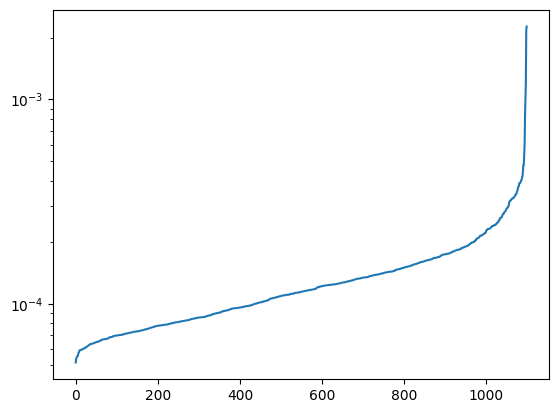

In [33]:
plt.semilogy(np.sort(sigma))

In [15]:
fudge_vals = np.linspace(0.8,1.7,10)
offset_vals = np.linspace(0.,1.5e-4,10)
result = np.zeros((len(fudge_vals), len(offset_vals)))
for i,f in enumerate(tqdm(fudge_vals)):
    for j,o in enumerate(offset_vals):
        model = copy.deepcopy(loaded[1])
        #print(model.sigma_fudge_FGS, model.sigma_offset)
        model.sigma_fudge_FGS = f
        #model.sigma_fudge_AIRS_mean = 1.
        #model.sigma_fudge_AIRS_var = 1.
        model.sigma_offset = [o,0.]
        inferred_data = model.infer(train_data);
        inferred_data[0].spectrum_cov[0,0]
        result[i,j] = kgs.score_metric(inferred_data,train_data,print_results=False)[0]

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [04:11<00:00, 25.12s/it]


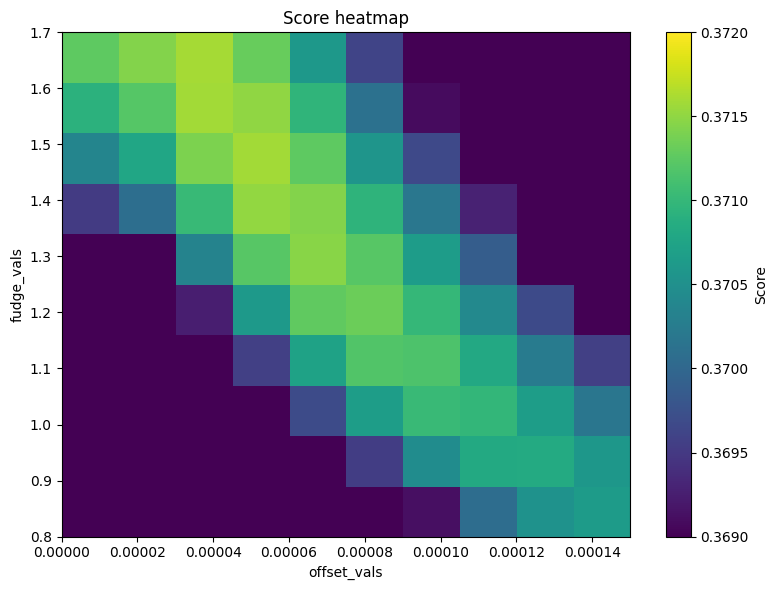

In [16]:
plt.figure(figsize=(8,6))
im = plt.imshow(result, 
                origin="lower", 
                aspect="auto", 
                extent=[offset_vals[0], offset_vals[-1],
                        fudge_vals[0], fudge_vals[-1]])
plt.clim([0.369, 0.372])
plt.colorbar(im, label="Score")

plt.xlabel("offset_vals")
plt.ylabel("fudge_vals")

plt.title("Score heatmap")
plt.tight_layout()
plt.show()